Epoch 1/100
2/2 - 2s - 1s/step - accuracy: 0.4314 - loss: 0.9584 - val_accuracy: 0.5385 - val_loss: 0.7199
Epoch 2/100
2/2 - 0s - 18ms/step - accuracy: 0.5490 - loss: 0.9022 - val_accuracy: 0.3846 - val_loss: 0.7323
Epoch 3/100
2/2 - 0s - 18ms/step - accuracy: 0.5882 - loss: 0.8603 - val_accuracy: 0.3077 - val_loss: 0.7478
Epoch 4/100
2/2 - 0s - 21ms/step - accuracy: 0.5882 - loss: 1.0052 - val_accuracy: 0.3846 - val_loss: 0.7544
Epoch 5/100
2/2 - 0s - 19ms/step - accuracy: 0.4510 - loss: 1.0759 - val_accuracy: 0.3846 - val_loss: 0.7573
Epoch 6/100
2/2 - 0s - 18ms/step - accuracy: 0.5490 - loss: 0.7607 - val_accuracy: 0.3846 - val_loss: 0.7612
Epoch 7/100
2/2 - 0s - 18ms/step - accuracy: 0.5882 - loss: 0.8575 - val_accuracy: 0.3077 - val_loss: 0.7622
Epoch 8/100
2/2 - 0s - 19ms/step - accuracy: 0.5686 - loss: 0.8526 - val_accuracy: 0.3077 - val_loss: 0.7646
Epoch 9/100
2/2 - 0s - 19ms/step - accuracy: 0.5294 - loss: 0.9894 - val_accuracy: 0.3077 - val_loss: 0.7636
Epoch 10/100
2/2 - 0s

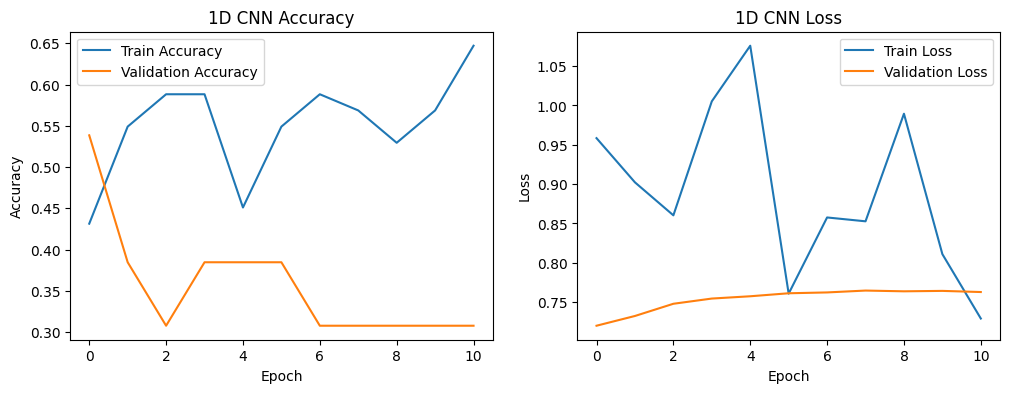

CNN and VGG16 Models saved successfully!


In [12]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Directory paths
base_path = 'PhishingVoiceDataset'
phishing_path = os.path.join(base_path, 'Phishing')
non_phishing_path = os.path.join(base_path, 'NonPhishing')

# Function to extract features
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=3.0)  # Ensuring uniform duration
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_mean = np.mean(chroma.T, axis=0)
        
        # Extract Spectral Contrast
        spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        spec_contrast_mean = np.mean(spec_contrast.T, axis=0)
        
        # Extract Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)
        tonnetz_mean = np.mean(tonnetz.T, axis=0)
        
        # Concatenate all features
        feature_vector = np.hstack([mfccs_mean, chroma_mean, spec_contrast_mean, tonnetz_mean])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    return feature_vector

# Parse files and extract features
features = []
labels = []

for folder, label in [(phishing_path, 1), (non_phishing_path, 0)]:
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if file_path.endswith('.mp3'):
            mfccs = extract_features(file_path)
            if mfccs is not None:
                features.append(mfccs)
                labels.append(label)

# Convert into Pandas DataFrame
features_df = pd.DataFrame(features)
features_df['label'] = labels

# Handling Class Imbalance using SMOTE
X = features_df.drop('label', axis=1)
y = features_df['label']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, test_size=0.2, random_state=42, stratify=y_res)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# 1D CNN Model

# Reshape data for 1D CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define 1D CNN model
cnn_model_1d = Sequential([
    Conv1D(32, kernel_size=3, activation=None, input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=3, activation=None),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation=None),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.4),
    
    Dense(2, activation='softmax')
])

# Compile the model
cnn_model_1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_1d = cnn_model_1d.fit(
    X_train_cnn, y_train_cat, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stop], 
    verbose=2
)

# Evaluate the 1D CNN model
loss, accuracy = cnn_model_1d.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"1D CNN Model Accuracy: {accuracy * 100:.2f}%")

# VGG16 Transfer Learning

# Function to pad features to 32x32
def pad_features(feature_array, target_shape=(32, 32, 3)):
    padded_array = np.zeros(target_shape)
    # Replicate the single-channel feature into 3 channels (for RGB-like input)
    feature_3ch = np.repeat(feature_array[:, np.newaxis], 3, axis=1)
    padded_array[:feature_3ch.shape[0], :feature_3ch.shape[1], :] = feature_3ch
    return padded_array

# Replicate 1-channel audio features into 3 channels
X_train_rgb = np.repeat(X_train_cnn, 3, axis=-1)  # Replicate to get (samples, timesteps, 3 channels)
X_test_rgb = np.repeat(X_test_cnn, 3, axis=-1)

# Pad the features to (32, 32, 3)
X_train_rgb_padded = np.array([pad_features(f, target_shape=(32, 32, 3)) for f in X_train_rgb])
X_test_rgb_padded = np.array([pad_features(f, target_shape=(32, 32, 3)) for f in X_test_rgb])

# Use VGG16 with the padded input shape
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze VGG layers to prevent training
for layer in vgg.layers:
    layer.trainable = False

# Add custom layers on top
model_vgg = Sequential([
    vgg,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

# Compile the VGG16-based model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16-based model
history_vgg = model_vgg.fit(
    X_train_rgb_padded, y_train_cat, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stop], 
    verbose=2
)

# Evaluate the VGG16-based model
loss, accuracy = model_vgg.evaluate(X_test_rgb_padded, y_test_cat, verbose=0)
print(f"VGG16 Model Accuracy: {accuracy * 100:.2f}%")

# Plot Training History for 1D CNN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_1d.history['accuracy'], label='Train Accuracy')
plt.plot(history_1d.history['val_accuracy'], label='Validation Accuracy')
plt.title('1D CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1d.history['loss'], label='Train Loss')
plt.plot(history_1d.history['val_loss'], label='Validation Loss')
plt.title('1D CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the CNN and VGG16 models
cnn_model_1d.save('cnn_1d_phishing_model.h5')
model_vgg.save('vgg16_phishing_model.h5')
print("CNN and VGG16 Models saved successfully!")


In [8]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import joblib

# Function to extract features (same as training)
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=3.0)  # Ensuring uniform duration
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_mean = np.mean(chroma.T, axis=0)
        
        # Extract Spectral Contrast
        spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        spec_contrast_mean = np.mean(spec_contrast.T, axis=0)
        
        # Extract Tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)
        tonnetz_mean = np.mean(tonnetz.T, axis=0)
        
        # Concatenate all features
        feature_vector = np.hstack([mfccs_mean, chroma_mean, spec_contrast_mean, tonnetz_mean])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    return feature_vector

# Function to pad features for VGG16 model (32x32x3)
def pad_features(feature_array, target_shape=(32, 32, 3)):
    padded_array = np.zeros(target_shape)
    feature_3ch = np.repeat(feature_array[:, np.newaxis], 3, axis=1)  # Replicate to 3 channels
    padded_array[:feature_3ch.shape[0], :feature_3ch.shape[1], :] = feature_3ch
    return padded_array

# Load the saved models
cnn_model_1d = load_model('cnn_1d_phishing_model.h5')
vgg16_model = load_model('vgg16_phishing_model.h5')

# Load the scaler and PCA (if you used them in training)
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')

# Function to predict using 1D CNN model
def predict_1d_cnn(features):
    features_scaled = scaler.transform([features])  # Scale the features
    features_pca = pca.transform(features_scaled)   # Apply PCA
    features_cnn = features_pca.reshape(1, features_pca.shape[1], 1)  # Reshape for CNN
    
    prediction = cnn_model_1d.predict(features_cnn)
    class_idx = np.argmax(prediction, axis=1)[0]  # Get class with highest probability
    return class_idx, prediction[0]

# Function to predict using VGG16 model
def predict_vgg16(features):
    features_scaled = scaler.transform([features])  # Scale the features
    features_pca = pca.transform(features_scaled)   # Apply PCA
    features_rgb = np.repeat(features_pca[:, np.newaxis], 3, axis=1)  # Replicate to 3 channels
    features_padded = pad_features(features_rgb, target_shape=(32, 32, 3))  # Pad the features
    features_padded = features_padded.reshape(1, 32, 32, 3)  # Reshape for VGG16
    
    prediction = vgg16_model.predict(features_padded)
    class_idx = np.argmax(prediction, axis=1)[0]  # Get class with highest probability
    return class_idx, prediction[0]

# Directory containing audio files to test
test_folder_path = '/mnt'

# Prepare results storage
results = []

# Loop through each audio file in the folder
for file_name in os.listdir(test_folder_path):
    if file_name.endswith('.mp3'):  # Ensure you process only MP3 files
        file_path = os.path.join(test_folder_path, file_name)
        print(f"Processing file: {file_path}")
        
        # Extract features
        features = extract_features(file_path)
        
        if features is not None:
            # Predict with 1D CNN
            class_idx_cnn, prob_cnn = predict_1d_cnn(features)
            cnn_result = f"1D CNN Prediction for {file_name}: Class {class_idx_cnn}, Probabilities: {prob_cnn}"
            print(cnn_result)

            # Predict with VGG16
            class_idx_vgg, prob_vgg = predict_vgg16(features)
            vgg_result = f"VGG16 Prediction for {file_name}: Class {class_idx_vgg}, Probabilities: {prob_vgg}"
            print(vgg_result)

            # Store results for this file
            results.append({
                'file': file_name,
                'cnn_class': class_idx_cnn,
                'cnn_prob': prob_cnn,
                'vgg_class': class_idx_vgg,
                'vgg_prob': prob_vgg
            })
        else:
            print(f"Failed to extract features for {file_name}")

# Optional: Save results to a file (CSV or text)
import csv

with open('phishing_detection_results.csv', mode='w', newline='') as csv_file:
    fieldnames = ['file', 'cnn_class', 'cnn_prob', 'vgg_class', 'vgg_prob']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for result in results:
        writer.writerow(result)

print("Batch prediction completed. Results saved to phishing_detection_results.csv.")


Batch prediction completed. Results saved to phishing_detection_results.csv.
